In [268]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [269]:
df = pd.read_csv("train_dataset.csv")
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18137 entries, 0 to 18136
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          18137 non-null  int64  
 1   no_of_children                        18137 non-null  int64  
 2   no_of_weekend_nights                  18137 non-null  int64  
 3   no_of_week_nights                     18137 non-null  int64  
 4   type_of_meal_plan                     18137 non-null  int64  
 5   required_car_parking_space            18137 non-null  int64  
 6   room_type_reserved                    18137 non-null  int64  
 7   lead_time                             18137 non-null  int64  
 8   arrival_year                          18137 non-null  int64  
 9   arrival_month                         18137 non-null  int64  
 10  arrival_date                          18137 non-null  int64  
 11  market_segment_

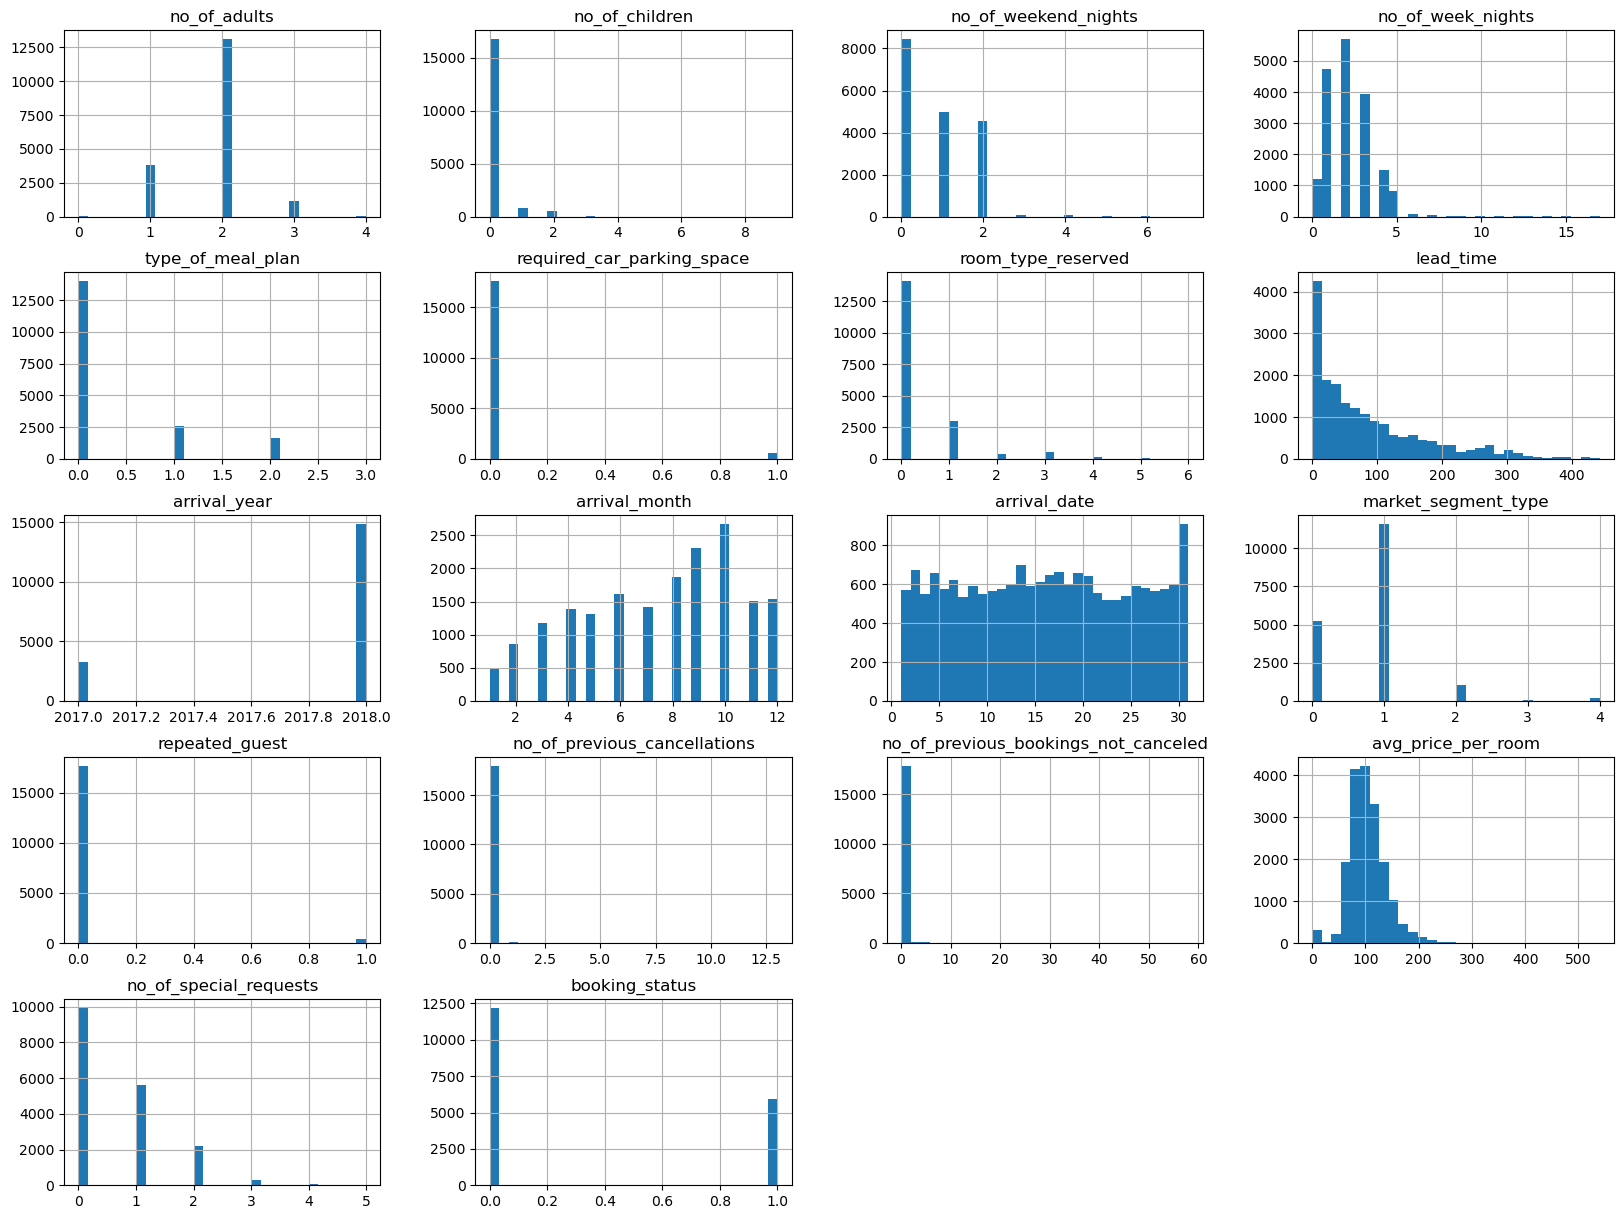

In [271]:
df.hist(bins=30, figsize=(20,15))
plt.show()

In [272]:
df = df[df["avg_price_per_room"] != 0].copy()

In [273]:
(df["lead_time"] == 0).sum()

np.int64(584)

In [274]:
anzahl = ((df["lead_time"] == 0) & (df["booking_status"] == 1)).sum()
print("lead_time=0 und storniert:", anzahl)

lead_time=0 und storniert: 33


In [275]:
#Bucketizing
df["n_lead_time"] = pd.cut(df["lead_time"],bins=[-0.5, 7, 30, 90, np.inf],labels=[0, 1, 2, 3]).astype(int)

In [276]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["booking_status"])   # Features
y = df["booking_status"]                  # Zielvariable

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, stratify=df["booking_status"], random_state=42)


In [277]:
corr_view = Xtrain.copy()

In [278]:
corr_view.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14282 entries, 6099 to 7239
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14282 non-null  int64  
 1   no_of_children                        14282 non-null  int64  
 2   no_of_weekend_nights                  14282 non-null  int64  
 3   no_of_week_nights                     14282 non-null  int64  
 4   type_of_meal_plan                     14282 non-null  int64  
 5   required_car_parking_space            14282 non-null  int64  
 6   room_type_reserved                    14282 non-null  int64  
 7   lead_time                             14282 non-null  int64  
 8   arrival_year                          14282 non-null  int64  
 9   arrival_month                         14282 non-null  int64  
 10  arrival_date                          14282 non-null  int64  
 11  market_segment_typ

In [279]:
def binarize_features(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df["n_" + col] = (df[col] > 0).astype(int)
        else:
            print(f"{col} nicht gefunden")
    return df


In [280]:
# Umwandlung Binär: 0 = kein Wochenende 1=Wochenende
#corr_view["n_is_weekend"] = (corr_view["no_of_weekend_nights"] > 0).astype(int)
#corr_view["n_was_cancelled"] = (corr_view["no_of_previous_cancellations"] > 0).astype(int)
#corr_view["n_is_familie"] = (corr_view["no_of_children"] > 0).astype(int)
#corr_view["n_room_type_bin"] = (corr_view["room_type_reserved"] != 0).astype(int) 

corr_view=binarize_features(corr_view, ["no_of_weekend_nights","no_of_previous_cancellations","no_of_children","room_type_reserved"])

In [281]:

corr_view["n_cut_special_request"] = pd.cut(corr_view["no_of_special_requests"],  bins=[-0.5,0.5,1.5,np.inf], labels=[0,1,2]).astype(int)

# 0 | 1 | 2-4
corr_view["n_market_segment_bin"] = pd.cut(corr_view["market_segment_type"],bins=[-0.5, 0.5, 1.5, np.inf],labels=[0, 1, 2],include_lowest=True).astype(int)

# Winter, Frühling, Sommer, Herbst, Winter # 5 Intervalle → 5 Labels
corr_view["n_arrival_season"] = pd.cut(corr_view["arrival_month"],bins=[0,3,6,9,12],labels=[1, 2, 3, 4],include_lowest=True).astype(int)


#Entlastung avg_price_per_room
corr_view["n_avg_price_per_room"] = np.log10(corr_view["avg_price_per_room"])

# 0 = sehr kurzfristig, 1 = kurzfristig, 2 = mittelfristig, 3 = langfristig
#Bucketizing
#corr_view["n_lead_time"] = pd.cut(corr_view["lead_time"],bins=[-0.5, 7, 30, 90, np.inf],labels=[0, 1, 2, 3]).astype(int)


"""
corr_view = corr_view[["n_lead_time",
                       "n_is_weekend",
                       "n_room_type_bin",
                       "n_is_familie",
                       "n_arrival_season",
                       "n_market_segment_bin",
                       "n_was_cancelled",
                       "n_cut_special_request"]]
"""

'\ncorr_view = corr_view[["n_lead_time",\n                       "n_is_weekend",\n                       "n_room_type_bin",\n                       "n_is_familie",\n                       "n_arrival_season",\n                       "n_market_segment_bin",\n                       "n_was_cancelled",\n                       "n_cut_special_request"]]\n'

In [282]:
corr_view["booking_status"] = ytrain
corr_matrix = corr_view.select_dtypes(include=["number"]).corr()
corr_matrix["booking_status"].sort_values(ascending=False)

booking_status                          1.000000
lead_time                               0.425968
n_lead_time                             0.360958
arrival_year                            0.178806
n_avg_price_per_room                    0.135950
avg_price_per_room                      0.123786
no_of_week_nights                       0.095746
no_of_adults                            0.087191
type_of_meal_plan                       0.076321
no_of_weekend_nights                    0.049710
n_no_of_weekend_nights                  0.039199
no_of_children                          0.030014
n_room_type_reserved                    0.028772
room_type_reserved                      0.026241
n_no_of_children                        0.024913
arrival_date                            0.010159
n_arrival_season                        0.006279
n_market_segment_bin                    0.000050
market_segment_type                    -0.002916
arrival_month                          -0.006066
no_of_previous_cance

In [283]:

corr_view = corr_view[["n_lead_time",
                       "n_avg_price_per_room",
                       "n_no_of_weekend_nights",
                       "n_room_type_reserved",
                       "n_no_of_children",
                       "n_arrival_season",
                       "n_market_segment_bin",
                       #"n_no_of_previous_cancellations",
                       "n_cut_special_request",
                       "booking_status"]]
                

In [284]:
corr_matrix = corr_view.select_dtypes(include=["number"]).corr()
corr_matrix["booking_status"].sort_values(ascending=False)

booking_status            1.000000
n_lead_time               0.360958
n_avg_price_per_room      0.135950
n_no_of_weekend_nights    0.039199
n_room_type_reserved      0.028772
n_no_of_children          0.024913
n_arrival_season          0.006279
n_market_segment_bin      0.000050
n_cut_special_request    -0.253527
Name: booking_status, dtype: float64

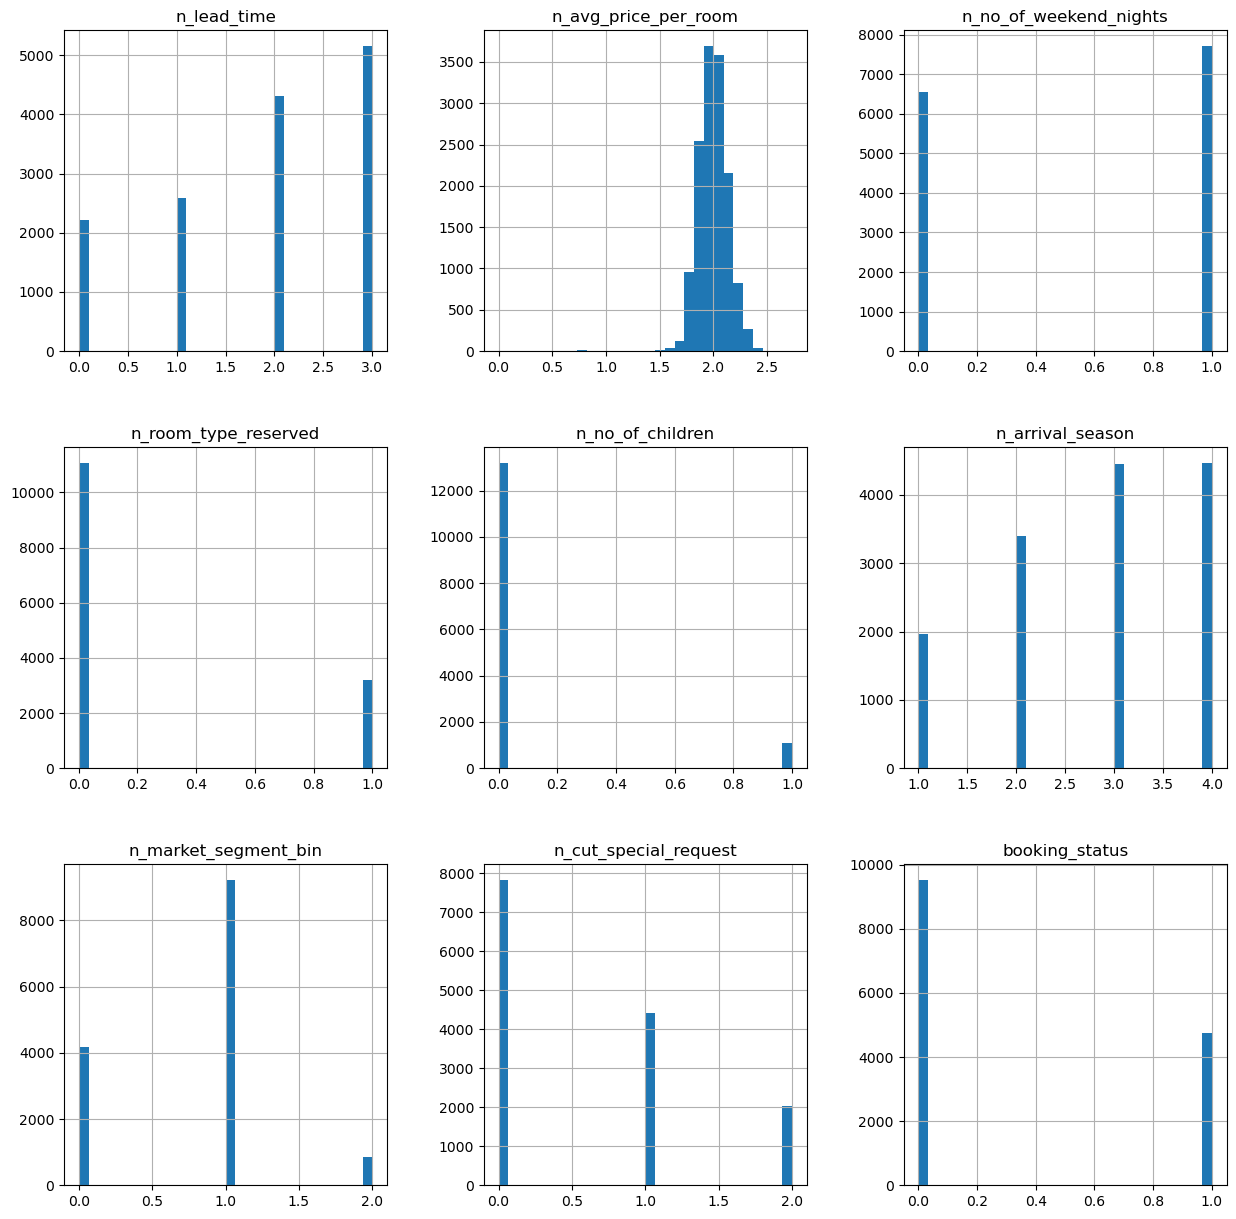

In [285]:
corr_view.hist(bins=30, figsize=(15,15))
plt.show()

In [286]:
corr_view["n_cut_special_request"]

6099     1
10601    0
13388    0
13645    2
13728    1
        ..
17791    2
8260     0
2874     0
7655     0
7239     0
Name: n_cut_special_request, Length: 14282, dtype: int64

Notiz:
lead_time hat die höchste Korrelation <br>
arrival_year wird vermutlich nur eine hohe Korrelation haben weil wir nur zwei Jahre haben, also ein bias - rausnehmen <br>
avg_price_per room würde ich drin lassen- evt gibt es noch eine kombi mit anderen Merkmalen die hilfreich wäre für eine besser Korrelation <br>
no of week nights würde ich noch drin lassen <br>
no of adulds auch und sonst nichts mehr das positiv korreliert

no of special requests sollte definitiv drin bleiben - ein binärmerkmal hat keine bessere korrelation ergeben aber könnte später für modelle evt besser sein zu verarbeiten z.B. Baum <br>
repeated guest hat auch eine hohe negative Korrelation aber der datensatz bietet nur wenige an die wiederholt haben, dass könnte dann auch eher ein bias StopIteration <br>
requiered car parking ist im Endefekt wie repeated guest - hat eine halbwegs hohe korrelation aber könnte auche ein Bias sein <br>



In [287]:
df = pd.read_csv("train_dataset.csv")

In [288]:
df = df[df["avg_price_per_room"] != 0].copy()
#df = df[df["lead_time"] != 0].copy()
df["lead_time"] = df["lead_time"].replace(0, 1)


In [289]:
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


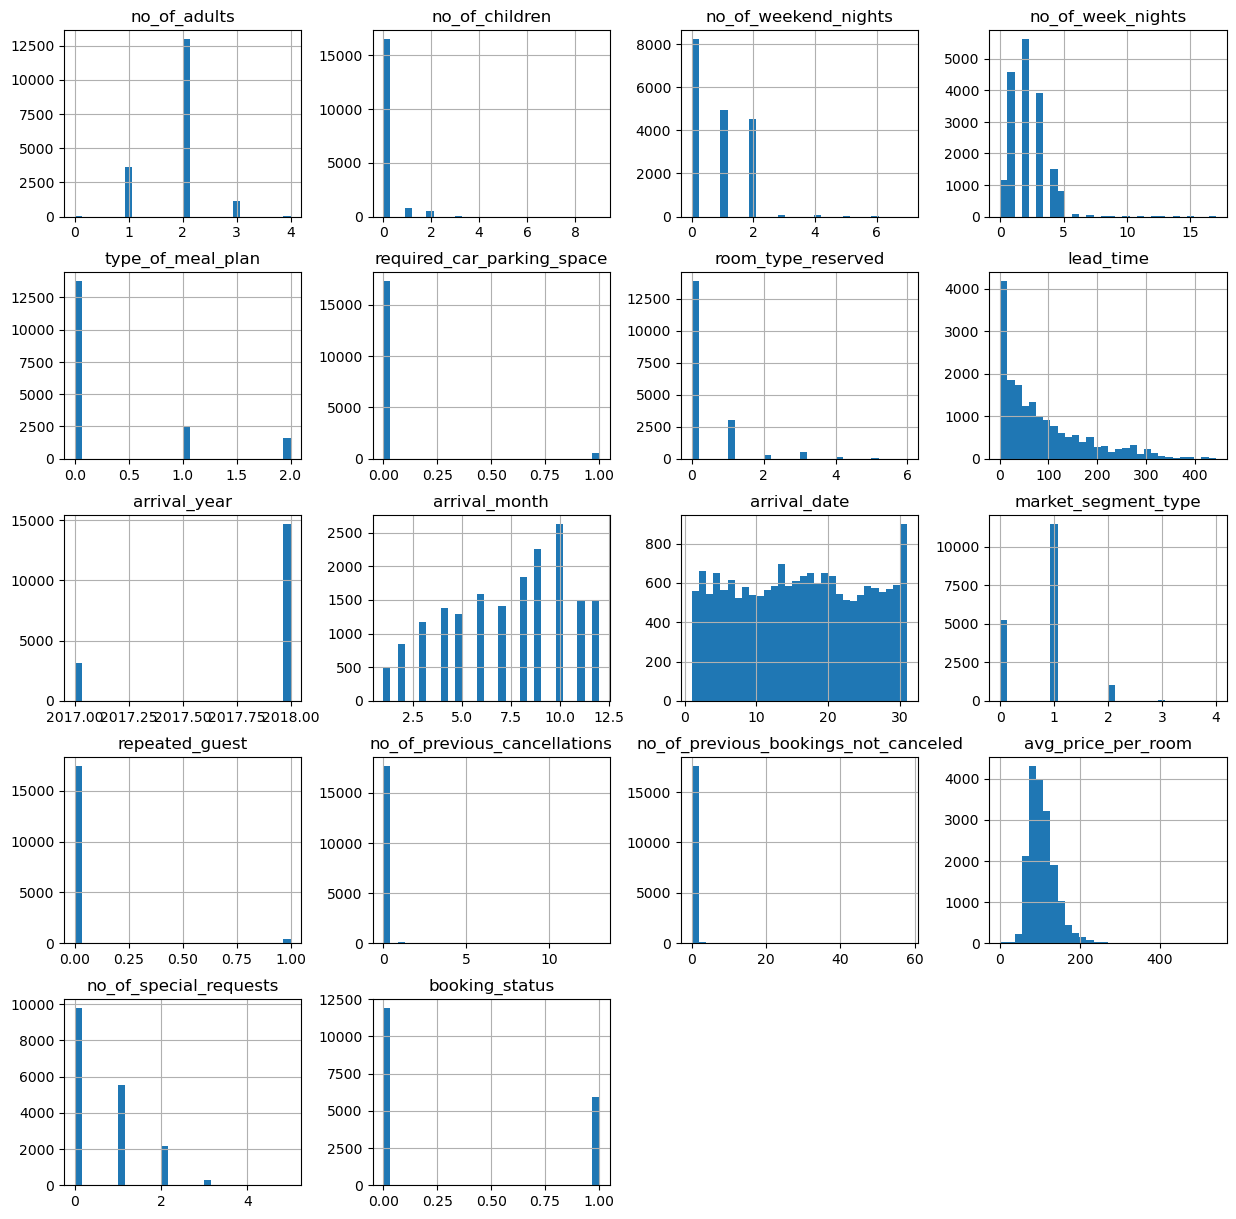

In [290]:
df.hist(bins=30, figsize=(15,15))
plt.show()

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17853 entries, 0 to 18136
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          17853 non-null  int64  
 1   no_of_children                        17853 non-null  int64  
 2   no_of_weekend_nights                  17853 non-null  int64  
 3   no_of_week_nights                     17853 non-null  int64  
 4   type_of_meal_plan                     17853 non-null  int64  
 5   required_car_parking_space            17853 non-null  int64  
 6   room_type_reserved                    17853 non-null  int64  
 7   lead_time                             17853 non-null  int64  
 8   arrival_year                          17853 non-null  int64  
 9   arrival_month                         17853 non-null  int64  
 10  arrival_date                          17853 non-null  int64  
 11  market_segment_type 

In [ ]:

def binarize_df(X):
    if isinstance(X, pd.DataFrame):
        return (X > 0).astype(int)
    return (X > 0).astype(int)

def cut_special_request(X):
    s = pd.Series(pd.DataFrame(X).iloc[:, 0])  
    out = pd.cut(s, bins=[-0.5, 0.5, 1.5, np.inf], labels=[0,1,2]).astype(int)
    return out.to_numpy().reshape(-1, 1)

def cut_market_segment(X):
    s = pd.Series(pd.DataFrame(X).iloc[:, 0])
    out = pd.cut(s, bins=[-0.5, 0.5, 1.5, np.inf], labels=[0,1,2], include_lowest=True).astype(int)
    return out.to_numpy().reshape(-1, 1)

def cut_arrival_season(X):
    s = pd.Series(pd.DataFrame(X).iloc[:, 0])
    out = pd.cut(s, bins=[0,3,6,9,12], labels=[1,2,3,4], include_lowest=True).astype(int)
    return out.to_numpy().reshape(-1, 1)





In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer


#transit_attribs = ["lead_time"]

# zu binäre Attribute 
bin_attribs = [   "no_of_children",
                  "required_car_parking_space",
                  "type_of_meal_plan"
                  ]

# Kategorische Attribute (werden one-hot encodiert)
cat_attribs = [
   "no_of_weekend_nights",
    "room_type_reserved"
    ]

# Numerische Attribute (werden skaliert)
log_scale_attribs = ["avg_price_per_room"]


# Box-Cox Transformation für lead_time
leadtime_pipeline = Pipeline([
    ("boxcox", PowerTransformer(method="box-cox", standardize=True))
])


cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


bin_pipeline = Pipeline([
    ("bin", FunctionTransformer(binarize_df, validate=False, feature_names_out="one-to-one"))
])

log_scale_pipeline = Pipeline([
    ("log", FunctionTransformer(np.log1p, validate=False, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])


special_req_pipeline = Pipeline([
    ("cut_request",FunctionTransformer(cut_special_request, validate=False,feature_names_out="one-to-one")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) 


market_segment_pipeline =Pipeline([
("cut_segment",FunctionTransformer(cut_market_segment, validate=False,feature_names_out="one-to-one")),
("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) 


arrival_season_pipeline =Pipeline([
("cut_season",FunctionTransformer(cut_arrival_season, validate=False,feature_names_out="one-to-one")),
("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) 


# zusammenfügen aller Pipelines 
preprocess = ColumnTransformer([
    ("cut_request", special_req_pipeline, ["no_of_special_requests"]),
    ("cut_segment", market_segment_pipeline, ["market_segment_type"]),
    ("cut_season", arrival_season_pipeline, ["arrival_month"]),
    ("bin", bin_pipeline, bin_attribs,),
    ("cat", cat_pipeline, cat_attribs),
    ("log_scale", log_scale_pipeline, log_scale_attribs),
    ("leadtime", leadtime_pipeline, ["lead_time"]),
    
 ])

In [294]:
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


In [296]:
hoteldata_prepared = pd.DataFrame(
    preprocess.fit_transform(df),
    index=df.index,
    columns=preprocess.get_feature_names_out()
)

In [297]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0


In [298]:
hoteldata_prepared.head()

,cut_request__no_of_special_requests_0,cut_request__no_of_special_requests_1,cut_request__no_of_special_requests_2,cut_segment__market_segment_type_0,cut_segment__market_segment_type_1,cut_segment__market_segment_type_2,cut_season__arrival_month_1,cut_season__arrival_month_2,cut_season__arrival_month_3,cut_season__arrival_month_4,...,cat__no_of_weekend_nights_7,cat__room_type_reserved_0,cat__room_type_reserved_1,cat__room_type_reserved_2,cat__room_type_reserved_3,cat__room_type_reserved_4,cat__room_type_reserved_5,cat__room_type_reserved_6,log_scale__avg_price_per_room,leadtime__lead_time
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311050,0.676179
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.140521,-0.761033
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.108875,1.893255
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.556816,0.197451
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.121979,-0.990114


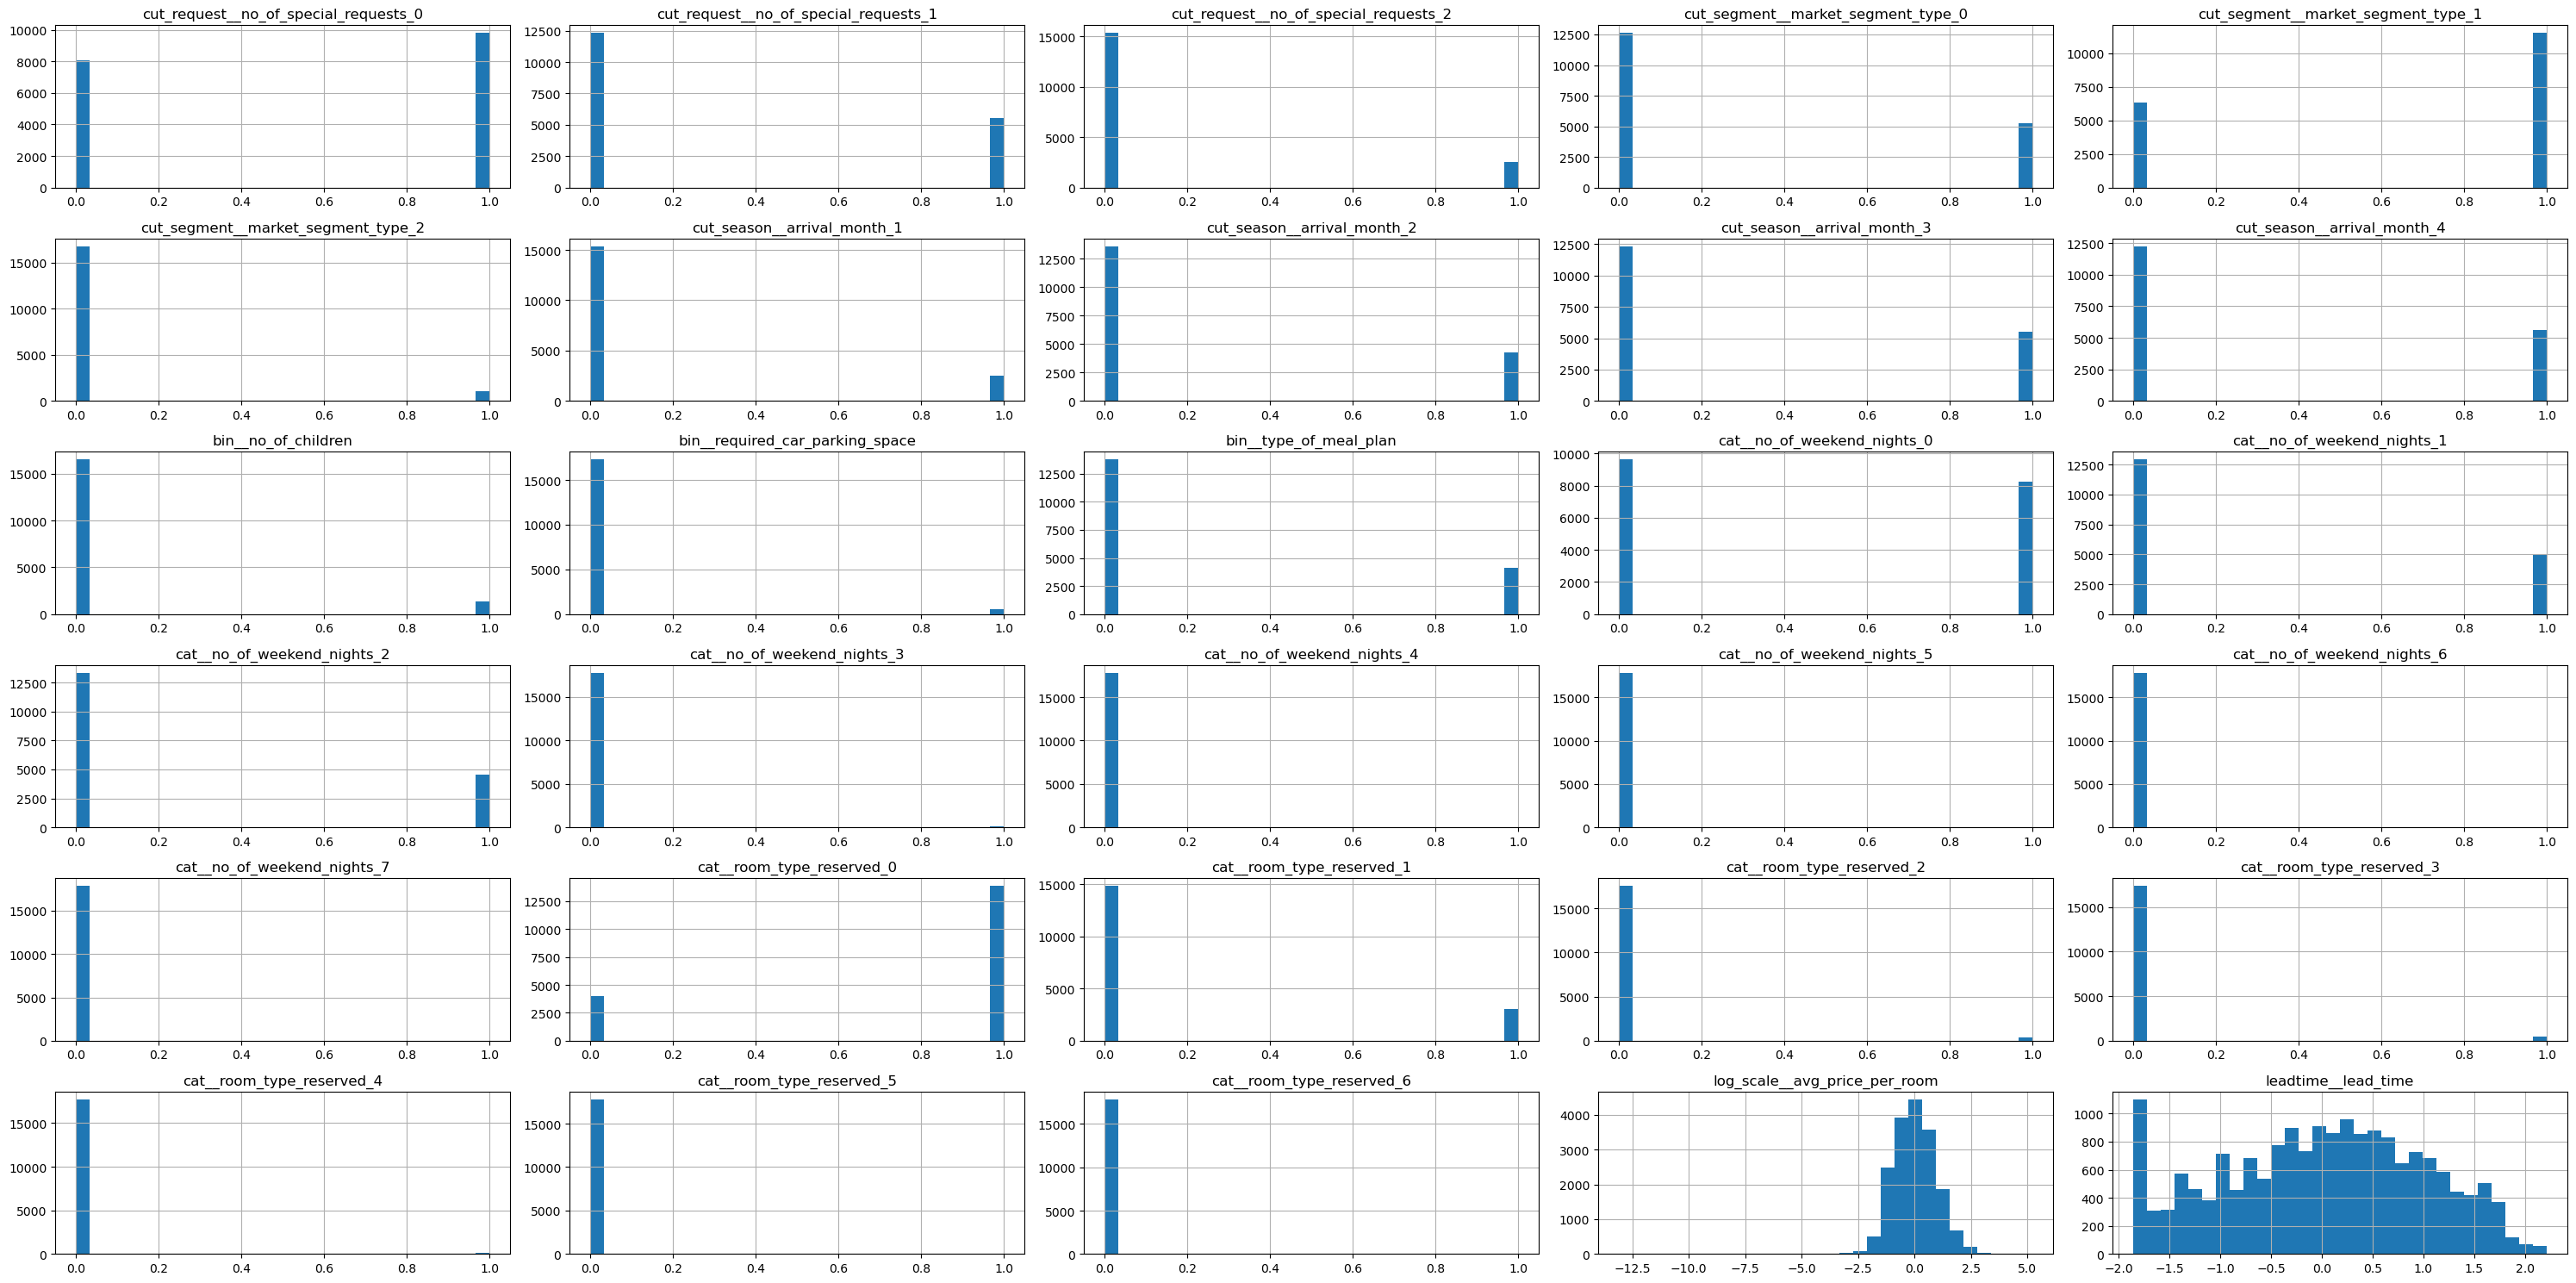

In [317]:
hoteldata_prepared.hist(bins=30, figsize=(30,15))

plt.tight_layout()
plt.show()

In [300]:
from sklearn.model_selection import train_test_split


# Features = alles außer der Zielspalte
X = hoteldata_prepared.copy()
y = df["booking_status"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [301]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict

# Modell aufsetzen
forest_clf = RandomForestClassifier(
    n_estimators=200,    # Anzahl Bäume
    max_depth=None,      # oder z.B. 10 begrenzen
    random_state=42,
    n_jobs=-1            # alle Kerne nutzen
)

# Training
forest_clf.fit(X_train, y_train)



from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten rf nicht optimiert")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))


cm = confusion_matrix(y_train, y_train_pred)
print(cm)

Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      9532
           1       0.81      0.77      0.79      4750

    accuracy                           0.86     14282
   macro avg       0.85      0.84      0.84     14282
weighted avg       0.86      0.86      0.86     14282

ROC-AUC (train): 0.922535945402743
[[8691  841]
 [1102 3648]]


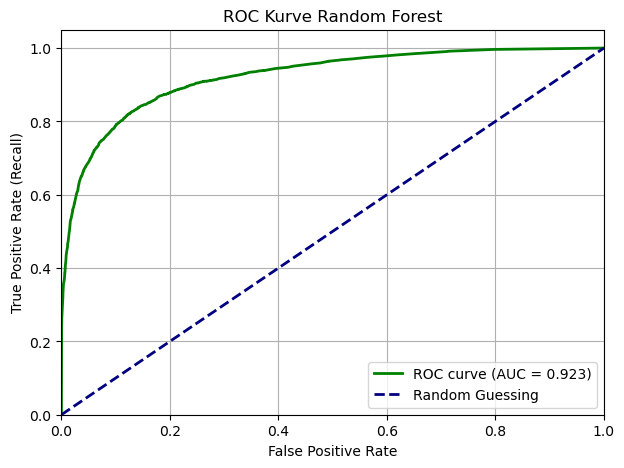

In [302]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC-Kurve (basierend auf Cross-Val-Probas)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="green", lw=2, label="ROC curve (AUC = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Kurve Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [303]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "class_weight": [None, "balanced", "balanced_subsample"]
}


gridf_prec = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    cv=5,
    scoring="average_precision", #"precision",   # hier Fokus auf Precision
    n_jobs=-1,
    #verbose=2
)

gridf_prec.fit(X_train, y_train)

print("Beste Parameter:", gridf_prec.best_params_)
print("CV beste Precision:", gridf_prec.best_score_)


Beste Parameter: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
CV beste Precision: 0.8930122848621858


In [304]:
forest_clf = RandomForestClassifier(
    n_estimators      = gridf_prec.best_params_.get("n_estimators"),
    max_depth         = gridf_prec.best_params_.get("max_depth"),
    min_samples_split = gridf_prec.best_params_.get("min_samples_split"),
    min_samples_leaf  = gridf_prec.best_params_.get("min_samples_leaf"),
    class_weight      = gridf_prec.best_params_.get("class_weight"),
    random_state=42,
    n_jobs=-1
)


# Training
forest_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [305]:
# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten rf optimiert auf precision")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))

cm = confusion_matrix(y_train, y_train_pred)
print(cm)

Cross-Val auf Trainingdaten rf optimiert auf precision
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      9532
           1       0.82      0.77      0.80      4750

    accuracy                           0.87     14282
   macro avg       0.86      0.84      0.85     14282
weighted avg       0.87      0.87      0.87     14282

ROC-AUC (train): 0.9249675110983502
[[8726  806]
 [1077 3673]]


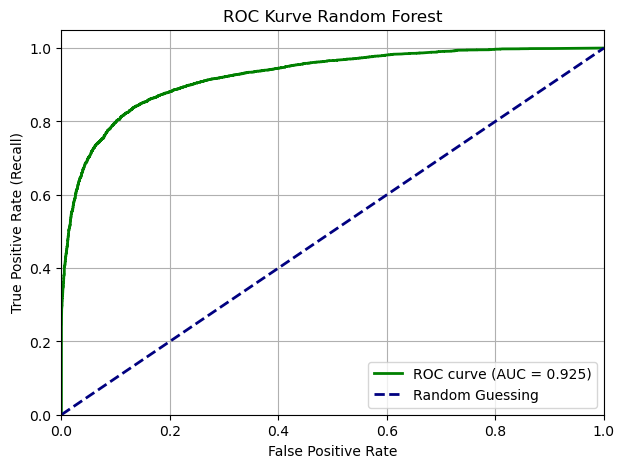

In [306]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC-Kurve (basierend auf Cross-Val-Probas)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="green", lw=2, label="ROC curve (AUC = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Kurve Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [307]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "class_weight": [None, "balanced", "balanced_subsample"]
}


gridf_recall = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    cv=5,
    scoring="recall",   # hier Fokus auf recall
    n_jobs=-1,
    #verbose=2
)

gridf_recall.fit(X_train, y_train)

print("Beste Parameter:", gridf_recall.best_params_)
print("CV beste Recall:", gridf_recall.best_score_)


Beste Parameter: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 400}
CV beste Recall: 0.8227368421052631


In [308]:

forest_clf = RandomForestClassifier(
    n_estimators      = gridf_recall.best_params_.get("n_estimators", 200),
    max_depth         = gridf_recall.best_params_.get("max_depth", None),
    min_samples_split = gridf_recall.best_params_.get("min_samples_split", 2),
    min_samples_leaf  = gridf_recall.best_params_.get("min_samples_leaf", 1),
    class_weight      = gridf_recall.best_params_.get("class_weight", None),
    random_state=42,
    n_jobs=-1
)


# Training
forest_clf.fit(X_train, y_train)

# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten optimiert auf recall")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))

cm = confusion_matrix(y_train, y_train_pred)
print(cm)

Cross-Val auf Trainingdaten optimiert auf recall
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      9532
           1       0.76      0.82      0.79      4750

    accuracy                           0.85     14282
   macro avg       0.83      0.84      0.84     14282
weighted avg       0.86      0.85      0.85     14282

ROC-AUC (train): 0.9154630828014224
[[8310 1222]
 [ 875 3875]]


In [309]:
from sklearn.linear_model import LogisticRegression

# Modell aufsetzen (l2-Regularisierung, Solver 'liblinear' oder 'lbfgs')
log_clf = LogisticRegression(
    penalty="l2",
    solver="liblinear",   # für kleinere Datensätze stabil
    random_state=42,
    max_iter=1000
)

# Trainieren
log_clf.fit(X_train, y_train)

# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(log_clf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(log_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten lr nicht optimiert")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))


cm = confusion_matrix(y_train, y_train_pred)
print(cm)


Cross-Val auf Trainingdaten lr nicht optimiert
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      9532
           1       0.73      0.63      0.68      4750

    accuracy                           0.80     14282
   macro avg       0.78      0.76      0.76     14282
weighted avg       0.79      0.80      0.79     14282

ROC-AUC (train): 0.858022141484639
[[8428 1104]
 [1765 2985]]


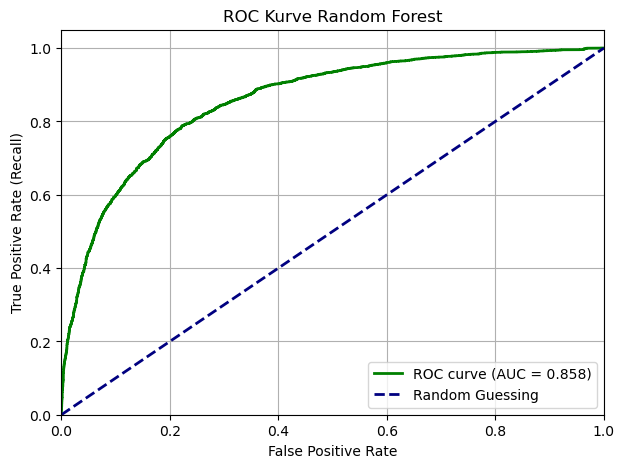

In [310]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC-Kurve (basierend auf Cross-Val-Probas)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="green", lw=2, label="ROC curve (AUC = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Kurve Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [311]:
from sklearn.model_selection import StratifiedKFold

# Basismodell
log_clf = LogisticRegression(max_iter=1000, random_state=42)

# Hyperparameter-Raster
param_grid_log = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10, 100],          # Regularisierungsstärke
    "solver": ["liblinear", "saga"],       # beide unterstützen l1
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch mit Precision als Ziel
grid_prec = GridSearchCV(
    estimator=log_clf,
    param_grid=param_grid_log,
    cv=cv,
    scoring="precision",
    n_jobs=-1,
    verbose=1
)

grid_prec.fit(X_train, y_train)

print("Beste Parameter (Precision):", grid_prec.best_params_)
print("CV beste Precision:", round(grid_prec.best_score_, 3))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/min

Beste Parameter (Precision): {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
CV beste Precision: 0.755


In [312]:
log_clf = LogisticRegression(
    penalty      = grid_prec.best_params_["penalty"],
    C            = grid_prec.best_params_["C"],
    solver       = grid_prec.best_params_["solver"],
    class_weight = grid_prec.best_params_["class_weight"],
    random_state = 42,
    max_iter     = 1000
)

# Trainieren
log_clf.fit(X_train, y_train)

# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(log_clf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(log_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten optimiert auf precision")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))


cm = confusion_matrix(y_train, y_train_pred)
print(cm)



Cross-Val auf Trainingdaten optimiert auf precision
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      9532
           1       0.76      0.60      0.67      4750

    accuracy                           0.80     14282
   macro avg       0.79      0.75      0.76     14282
weighted avg       0.80      0.80      0.80     14282

ROC-AUC (train): 0.8529359387768626
[[8626  906]
 [1923 2827]]


In [313]:
# GridSearch mit Recall als Ziel
grid_rec = GridSearchCV(
    estimator=log_clf,
    param_grid=param_grid_log,
    cv=cv,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

grid_rec.fit(X_train, y_train)

print("Beste Parameter (Recall):", grid_rec.best_params_)
print("CV bester Recall:", round(grid_rec.best_score_, 3))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tommi/min

Beste Parameter (Recall): {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
CV bester Recall: 0.8


/home/tommi/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [314]:
log_clf = LogisticRegression(
    penalty      = grid_rec.best_params_["penalty"],
    C            = grid_rec.best_params_["C"],
    solver       = grid_rec.best_params_["solver"],
    class_weight = grid_rec.best_params_["class_weight"],
    random_state = 42,
    max_iter     = 1000
)

# Trainieren
log_clf.fit(X_train, y_train)

# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(log_clf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(log_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten optimiert auf recall")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))

cm = confusion_matrix(y_train, y_train_pred)
print(cm)


Cross-Val auf Trainingdaten optimiert auf recall
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      9532
           1       0.61      0.80      0.70      4750

    accuracy                           0.77     14282
   macro avg       0.75      0.78      0.75     14282
weighted avg       0.79      0.77      0.77     14282

ROC-AUC (train): 0.8533694480641385
[[7138 2394]
 [ 944 3806]]


In [315]:

# Random Forest – best params aus deinem RF-Grid (ohne Pipeline)
rf_best = RandomForestClassifier(
    n_estimators      = gridf_prec.best_params_["n_estimators"],
    max_depth         = gridf_prec.best_params_["max_depth"],
    min_samples_split = gridf_prec.best_params_["min_samples_split"],
    min_samples_leaf  = gridf_prec.best_params_["min_samples_leaf"],
    class_weight      = gridf_prec.best_params_["class_weight"],
    random_state=42,
    n_jobs=-1
)

# Logistic Regression – nimm z.B. die PRECISION-optimierten Params
lr_best_prec = LogisticRegression(
    penalty      = grid_prec.best_params_["penalty"],
    C            = grid_prec.best_params_["C"],
    solver       = grid_prec.best_params_["solver"],
    class_weight = grid_prec.best_params_["class_weight"],
    random_state = 42,
    max_iter     = 1000
)


In [316]:
# Gleichgewichtete Wahrscheinlichkeiten; du kannst weights anpassen (z.B. RF etwas höher)
from sklearn.ensemble import VotingClassifier


vclf = VotingClassifier(
    estimators=[("rf", rf_best), ("lr", lr_best_prec)],
    voting="soft",
    weights=[1, 1],   # z.B. [2,1], wenn RF mehr Gewicht bekommen soll
    n_jobs=-1
)

vclf.fit(X_train, y_train)


# 1. Cross-Validation (nur auf Training!)
y_train_pred = cross_val_predict(vclf, X_train, y_train, cv=3, method="predict")
y_train_proba = cross_val_predict(vclf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

print("Cross-Val auf Trainingdaten ensamble soft rf lr optimiert auf precision")
print(classification_report(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))

cm = confusion_matrix(y_train, y_train_pred)
print(cm)


Cross-Val auf Trainingdaten ensamble soft rf lr optimiert auf precision
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      9532
           1       0.85      0.75      0.80      4750

    accuracy                           0.87     14282
   macro avg       0.86      0.84      0.85     14282
weighted avg       0.87      0.87      0.87     14282

ROC-AUC (train): 0.9182767299070168
[[8889  643]
 [1188 3562]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

# Mehrere Scorings parallel
scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "accuracy": "accuracy",
    "roc_auc": "roc_auc"
}

# GridSearch, aber nur eine Metrik zum Refit benutzen (z. B. precision)
grid = GridSearchCV(
    forest_clf,
    param_grid={
        "n_estimators": [200, 400],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 5],
        "class_weight": [None, "balanced"]
    },
    cv=5,
    scoring=scoring,
    refit="precision",   # <- bestimmt, welches Modell als best_estimator_ gespeichert wird
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Alle Scores für best_params_
print("Beste Parameter:", grid.best_params_)
print("CV beste avg Precision:", grid.cv_results_["mean_test_precision"][grid.best_index_])
print("CV beste avg Recall:",    grid.cv_results_["mean_test_recall"][grid.best_index_])
print("CV beste avg F1:",        grid.cv_results_["mean_test_f1"][grid.best_index_])
print("CV beste avg Accuracy:",  grid.cv_results_["mean_test_accuracy"][grid.best_index_])
print("CV beste avg ROC-AUC:",   grid.cv_results_["mean_test_roc_auc"][grid.best_index_])
